In [13]:
import helpsk as hlp

# Causal Inference for The Brave and True

Code and notes from `Causal Inference for The Brave and True`: https://matheusfacure.github.io/python-causality-handbook/landing-page.html

# 01 - Introduction to Causality

https://matheusfacure.github.io/python-causality-handbook/01-Introduction-To-Causality.html

In [1]:
tuition = 1000

tablet = 0
print(200 - 50 * tablet + 0.7 * tuition)

tablet = 1
print(200 - 50 * tablet + 0.7 * tuition)

900.0
850.0


In [2]:
tablet = 1

tuition = 800
print(200 - 50 * tablet + 0.7 * tuition)

tuition = 900
print(200 - 50 * tablet + 0.7 * tuition)

710.0
780.0


In [18]:
import pandas as pd
import numpy as np
from scipy.special import expit
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("fivethirtyeight")

np.random.seed(2)
n = 100
# tuition is normally distributed around $1000 with stand dev of $300
tuition = np.random.normal(1000, 300, n).round()
# converting the z-score of each tuition value to a probability (via expit) and then 
# drawing a random sample from binom distro such that the higher the tuition the more likely 
# the student has a tablet
tablet = np.random.binomial(1, expit((tuition - tuition.mean()) / tuition.std())).astype(bool)
# now we're creating a score where using a tablet actually has a negative impact on the score (lowers
# the score by an average of 50 points) but a higher tuition is associated with a higher score; and
# furthermore, the higher the tuition the more likely the student has a tablet (which, 
# again, lowers the score on average)
enem_score = np.random.normal(200 - 50 * tablet + 0.7 * tuition, 200)
enem_score = (enem_score - enem_score.min()) / enem_score.max()
enem_score *= 1000

data = pd.DataFrame(dict(enem_score=enem_score, Tuition=tuition, Tablet=tablet))
data.head()

,enem_score,Tuition,Tablet
0,460.210030,875.0,True
1,449.070621,983.0,False
2,119.040595,359.0,False
3,850.446358,1492.0,True
4,425.848369,462.0,False


**The first figure below makes it seem that having a tablet has a positive impact on ENEM score, even though we know it has a negative impact, which is shown in the second figure.**

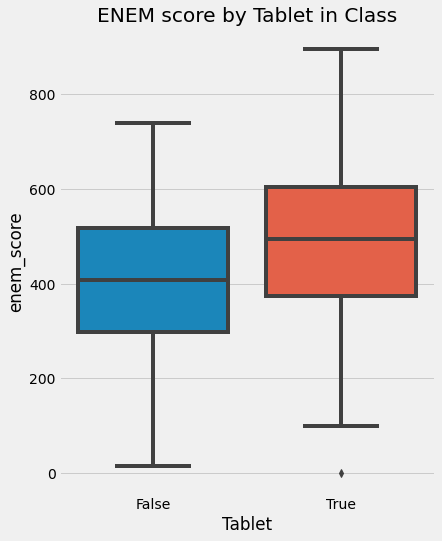

In [19]:
plt.figure(figsize=(6,8))
sns.boxplot(y="enem_score", x="Tablet", data=data).set_title('ENEM score by Tablet in Class')
plt.show()

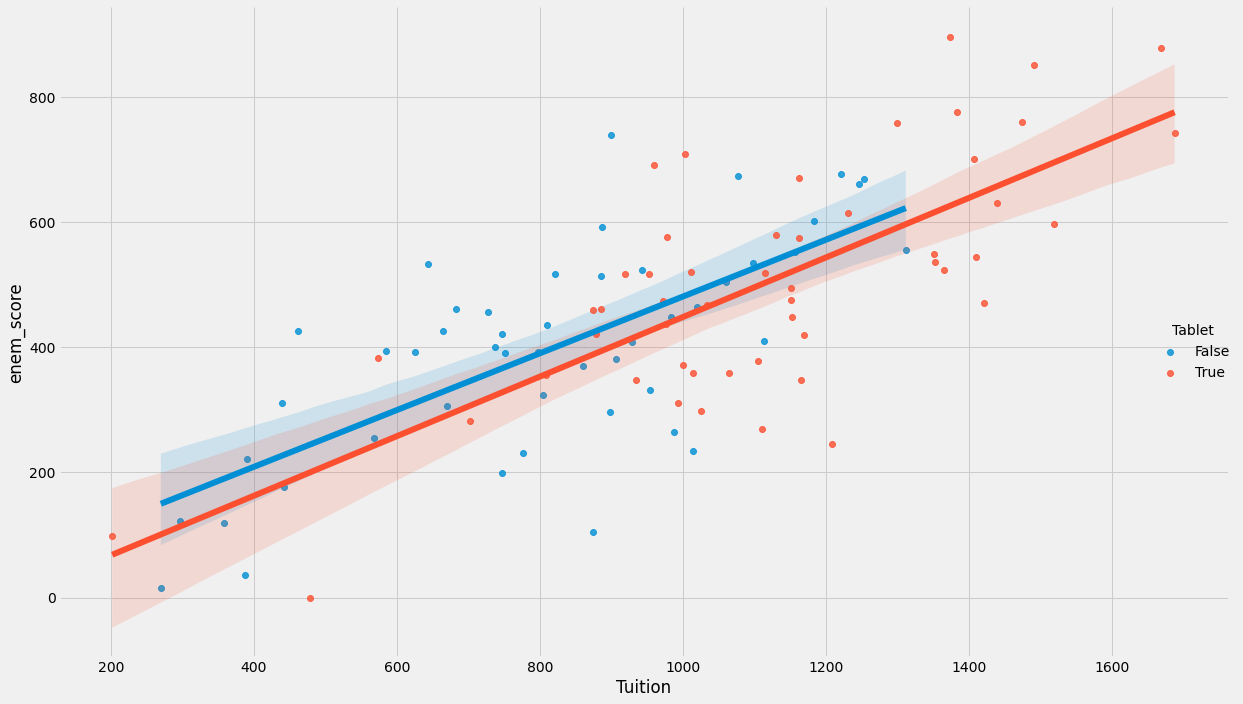

In [20]:
sns.lmplot(x='Tuition', y='enem_score', hue='Tablet', data=data, height=10, aspect=hlp.plot.GOLDEN_RATIO)
plt.tight_layout()

---

```
ATE = E[Y1 - Y0] (Causation)
```

```

ATT = E[Y1 - Y0 | T=1]
    = E[Y1 | T=1] - E[Y0 | T=1]
```

```
Association: E[Y1 | T=1] - E[Y0 | T=0]
```

i.e. association is the observed average of treatment - observed average of non-treatment

is the equation below the same as causation?

`(E[Y1 | T=1] - E[Y0 | T=1]) - (E[Y1 | T=0] - E[Y0 | T=0])`

The equation above is similar (or same?) to what diff and diff analysis tries to capture.

However, when the treated and the control group are, on average, the same i.e. equal BEFORE the treatment (i.e. causation) that implies `E[Y0 | T=1]` is equal to `E[Y0 | T=0]` which we'll say is equal to `X`

Therefore:

```
    = (E[Y1 | T=1] - E[Y0 | T=1]) - (E[Y1 | T=0] - E[Y0 | T=0])
    = (E[Y1 | T=1] - X) - (E[Y1 | T=0] - X) (substitution)
    = E[Y1 | T=1] - X - E[Y1 | T=0] + X (distribute `-`)
    = E[Y1 | T=1] - E[Y1 | T=0] - X + X (rearrange)
    = E[Y1 | T=1] - E[Y1 | T=0] (simplify)
```

Where `E[Y1 | T=0]` is a counterfactual that we wish we knew, which basically says that if we took outcome of the treated and subtracted the outcome of the control if they were to get treated (again, we can't know it), then we would have the causation effect



Whereas association is `E[Y | T=1] - E[Y | T=0]`, where
- `E[Y | T=1]` == `E[Y1 | T=1]`, and
- `E[Y | T=0]` == `E[Y0 | T=0]`

```
{ATT} + {Bias}
= {E[Y1 | T=1] - E[Y0 | T=1]} + {E[Y0 | T=1] - [E[Y0 | T=0]}

but assume E[Y0 | T=1] is equal to [E[Y0 | T=0], meaning that the treatment and control group are compareable before the treatment, then:

{E[Y0 | T=1] - [E[Y0 | T=0]} == 0

and we are left with

{E[Y1 | T=1] - E[Y0 | T=1]}

which ATT

but we can substitute `E[Y0 | T=1]` with `E[Y0 | T=0]`, so

ATT = E[Y1 | T=1] - E[Y0 | T=0]
    = average value of observed outcome of T=1 minus average value of observed outcome of T=0
ATT = Association

Meaning when T=1 and T=0 are the same before the treatment is given, then association is causation and ATE/ATT is the difference between the two groups.
```

---

# 02 - Randomised Experiments

https://matheusfacure.github.io/python-causality-handbook/02-Randomised-Experiments.html

In [26]:
data = pd.read_csv('https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/online_classroom.csv')
data

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,63.29997
1,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0,79.96000
2,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,83.37000
3,1,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,90.01994
4,1,0.0,0.0,0.0,0.0,0.0,1.0,1,0.0,83.30000
...,...,...,...,...,...,...,...,...,...,...
318,0,0.0,0.0,0.0,0.0,0.0,1.0,0,1.0,68.36000
319,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,70.05000
320,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,66.69000
321,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,83.29997


In [25]:
hlp.pandas.numeric_summary(data, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
gender,323,0,0.0%,136,42.0%,0.6,0.5,0.8,-0.3,-1.9,0.0,0.0,0.0,1.0,1.0,1.0,1.0
asian,247,76,24.0%,194,60.0%,0.2,0.4,1.9,1.4,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
black,247,76,24.0%,230,71.0%,0.1,0.2,3.7,3.4,9.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0
hawaiian,247,76,24.0%,244,76.0%,0.0,0.1,9.0,9.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
hispanic,247,76,24.0%,243,75.0%,0.0,0.1,7.8,7.7,58.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
unknown,247,76,24.0%,246,76.0%,0.0,0.1,15.7,15.7,247.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
white,247,76,24.0%,78,24.0%,0.7,0.5,0.7,-0.8,-1.4,0.0,0.0,0.0,1.0,1.0,1.0,1.0
format_ol,323,0,0.0%,229,71.0%,0.3,0.5,1.6,0.9,-1.1,0.0,0.0,0.0,0.0,1.0,1.0,1.0
format_blended,323,0,0.0%,214,66.0%,0.3,0.5,1.4,0.7,-1.5,0.0,0.0,0.0,0.0,1.0,1.0,1.0
falsexam,323,0,0.0%,2,1.0%,76.6,11.7,0.1,-2.0,10.2,0.0,62.0,70.0,78.3,85.0,88.3,96.7


In [35]:
(data
 #.replace(np.nan, 0)
 .assign(class_format = np.select(
    [data["format_ol"].astype(bool), data["format_blended"].astype(bool)],  # similar to case statements
    ["online", "blended"],  # value if corresponding condition above is true
    default="face_to_face"  # value if no condition above is true
))
 .groupby(["class_format"])
 .mean())

,gender,asian,black,hawaiian,hispanic,unknown,white,format_ol,format_blended,falsexam
class_format,,,,,,,,,,
blended,0.550459,0.217949,0.102564,0.025641,0.012821,0.012821,0.628205,0.0,1.0,77.093731
face_to_face,0.633333,0.202020,0.070707,0.000000,0.010101,0.000000,0.717172,0.0,0.0,78.547485
online,0.542553,0.228571,0.028571,0.014286,0.028571,0.000000,0.700000,1.0,0.0,73.635263


---

In [58]:
regression_data['class_format'].to_numpy().reshape(-1, 1)

array([['face_to_face'],
       ['face_to_face'],
       ['blended'],
       ['blended'],
       ['online'],
       ['online'],
       ['blended'],
       ['face_to_face'],
       ['face_to_face'],
       ['online'],
       ['online'],
       ['face_to_face'],
       ['face_to_face'],
       ['blended'],
       ['face_to_face'],
       ['blended'],
       ['online'],
       ['face_to_face'],
       ['blended'],
       ['online'],
       ['blended'],
       ['online'],
       ['face_to_face'],
       ['face_to_face'],
       ['online'],
       ['face_to_face'],
       ['face_to_face'],
       ['blended'],
       ['online'],
       ['online'],
       ['blended'],
       ['blended'],
       ['blended'],
       ['face_to_face'],
       ['face_to_face'],
       ['face_to_face'],
       ['face_to_face'],
       ['online'],
       ['face_to_face'],
       ['blended'],
       ['blended'],
       ['blended'],
       ['blended'],
       ['face_to_face'],
       ['face_to_face'],
       ['face_to

In [74]:
# regression_data = (data
#     #.replace(np.nan, 0)
#     .assign(class_format = np.select(
#     [data["format_ol"].astype(bool), data["format_blended"].astype(bool)],  # similar to case statements
#     ["online", "blended"],  # value if corresponding condition above is true
#     default="face_to_face"  # value if no condition above is true
# )))
#
# regression_data = regression_data[['falsexam', 'class_format']]

import statsmodels.formula.api as smf
result = smf.ols('falsexam ~ format_ol + format_blended + gender + black', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,76.3460,1.407,54.270,0.000,73.575,79.117
format_ol,-4.2338,1.647,-2.571,0.011,-7.477,-0.990
format_blended,-0.3802,1.593,-0.239,0.812,-3.519,2.758
gender,4.4134,1.371,3.220,0.001,1.714,7.113
black,-6.5706,2.658,-2.472,0.014,-11.806,-1.335


# 04 - Graphical Causal Models

https://matheusfacure.github.io/python-causality-handbook/04-Graphical-Causal-Models.html

> Imagine that with the help of some miracle you are finally able to randomize education in order to measure its effect on wage. But just to be sure you won’t have confounding, you control for a lot of variables. Among them, you control for investments. But investment is not a common cause of education and wage. Instead, it is a consequence of both. More educated people both earn more and invest more. Also, those who earn more invest more. **Since investment is a collider, by conditioning on it, you are opening a second path between the treatment and the outcome, which will make it harder to measure the direct effect.** One way to think about this is that by controlling investments, you are looking at **small groups of the population where investment is the same and then finding the effect of education on those groups**. But by doing so, **you are also indirectly and inadvertently not allowing wages to change much**. As a result, you **won’t be able to see how education changes wage, because you are not allowing wages to change as it should**.

> A similar thing happens when we condition on a mediator of the treatment. **A mediator is a variable between the treatment and the outcome. It, well, mediates the causal effect.** For example, suppose again you are able to randomize education. But, just to be sure, you decide to control whether or not the person had a white collar job. Once again, this conditioning biasses the causal effect estimation. This time, not because it opens a front door path with a collider, but because it closes one of the channels through which the treatment operates. In our example, *getting a white collar job is one way that more education leads to higher pay*. By controlling it, we close this channel and leave open only the direct effect of education on wage.

# 05 - The Unreasonable Effectiveness of Linear Regression

https://matheusfacure.github.io/python-causality-handbook/05-The-Unreasonable-Effectiveness-of-Linear-Regression.html

> Randomised Controlled Trials forces the treated and the untreated to be equal and that's why the bias vanishes.

>  First, the **bias term will be zero if the omitted variables have no impact on the dependent variable $Y$**. This makes total sense. I don't need to control for stuff that is irrelevant for wages when trying to understand the impact of education on it (like how tall the lilies of the field). Second, the **bias term will also be zero if the omitted variables have no impact on the treatment variable**. This also makes intuitive sense. If everything that impacts education has been included in the model, there is no way the estimated impact of education is mixed with a correlation from education on something else that also impacts wages.

> To put it more succinctly, we say that there is no OVB if all the confounding variables are accounted for in the model.

However, regarding statement above, by omitting variables that have no impact on the dependent variable, I believe A) our model is not as predictive and B) the standard errors of the coefficients in the model are larger than if the variables would have been included. This means that it's possible our variable of interest is not statistically significant when omitting and statistically significant when including the other variables.

> Causal graphs are excellent to depict our understanding of the world and understand how confounding bias works. In our first example, we have a graph where education causes wage: more education leads to higher wages. However, IQ also causes wage and it also causes education: high IQ causes both more education and wage. **If we don't account for IQ in our model, some of its effect on wage will flow through the correlation with education. That will make the impact of education look higher than it actually is. This is an example of positive bias.**

> Now, back to our question, is the parameter we’ve estimated for the impact of educ on wage causal? I’m sorry to bring it to you, **but that will depend on our ability to argue in favor or against that fact that all confounders have been included in the model**. Personally, I think they haven’t. For instance, we haven’t included *family wealth*. Even if we included family education, that can only be seen as a proxy for wealth. We’ve also not accounted for factors like personal ambition. It could be that ambition is what causes both more years of education and higher wage, so it is a confounder. This is to show that causal inference with non-random or observational data should always be taken with a grain of salt. We can never be sure that all confounders were accounted for.

---

# 06 - Grouped and Dummy Regression

> Grouped data like the one above are extremely common in data analysis. One reason for that is confidentiality. Governments and firms can't give away personal data because that would violate data privacy requirements they have to follow. If they need to export data to an outside researcher, they can only do it by means of grouping the data. This way, individuals get grouped together and are no longer uniquely identifiable.

> Fortunately for us, regression can handle those kinds of data pretty well.

> Regression doesn't need big data to work! What we can do is provide weights to our linear regression model. This way, it will consider groups with higher sample size more than the small groups. Notice how I've replaced the smf.ols with smf.wls, for weighted least squares. It's hard to notice, but it will make all the difference.

> Notice how the parameter estimate of educ in the grouped model is very close to the one in the ungrouped data (actually, they are the same in this case). Also, even with only 10 data points, we've managed to get a statistically significant coefficient. That's because, although we have fewer points, grouping also lowers the variance by a lot. Also notice how the **standard error is a bit larger**, as is the t statistics. That's because **some information about the variance is lost, so we have to be more conservative**. Once we group the data, **we don't know how large the variance is within each group**.

> To use weighted regression you need **mean statistics**. Not sums, not standard deviations, not medians, but means! For both the covariates and the dependent variable. Just keep in mind that the result of weighted regression with grouped data won't match exactly that of regression in ungrouped data, but it will be pretty similar.

---

# 07 - Beyond Confounders

https://matheusfacure.github.io/python-causality-handbook/07-Beyond-Confounders.html

## Good Controls

https://matheusfacure.github.io/python-causality-handbook/07-Beyond-Confounders.html#good-controls

> Sadly, the estimated ATE is -0.62, which is pretty weird. How can sending an email make late customers pay less than average? Still, the P-value is so high that this probably doesn’t mean anything. What you should do now? Go back to your team with a tail between your legs and say that the test is inconclusive and you need more data? Not so fast.

> First, let’s understand why we can fail to find statistical significance in a treatment even when it is there. **It could be that, like in this case, the treatment has very little impact on the outcome**. If you think about it, what makes people pay their debt is, by and large, *factors outside the control of the collections department*. People pay their debt because they find a new job, manage their finances, income and so on. In statistical terms, we can say that the variability of payments is explained much more by other factors other than by the email.

> Fortunately, **regression can help us lower this variability**. The trick is to use **additional controls**. If a variable is a good predictor of the outcome, it will explain away a lot of its variance. If risk and credit limit are good predictors of payment, we can control them to make it easier to find the impact of the email on payments. If we remember how regression works, this has an intuitive explanation. Adding extra variables to a regression means keeping them constant while looking at the treatment. So, the reasoning goes, if we look at similar levels of risk and credit limit, the variance of the response variable payments should be smaller. Or, in other words, if risk and credit line predicts payments very well, customers with a similar risk and credit line should also have similar payment levels, hence with less variance.

> To wrap it up, anytime we have a control that is a good predictor of the outcome, even if it is not a confounder, adding it to our model is a good idea. It helps lowering the variance of our treatment effect estimates. 


## Mostly Harmful Controls

https://matheusfacure.github.io/python-causality-handbook/07-Beyond-Confounders.html#mostly-harmful-controls

> As a second motivating example, let’s consider a drug test scenario with `2` hospitals. Both of them are conducting **randomised** trials on a new drug to treat a certain illness. The outcome of interest is days hospitalised. If the treatment is effective, it will lower the amount of days the patient stays in the hospital. For one of the hospitals, the policy regarding the random `treatment` is to give it to `90%` of its patients while 10% get a placebo. The other hospital has a **different policy**: it gives the `drug` to a random `10%` of its patients and 90% get a placebo. You are also told that **the hospital that gives 90% of the true drug and 10% of placebo usually gets more severe cases of the illness to treat**.

> Since you are dealing with randomized data, your first instinct is to simply run a regression of the outcome on the treatment.

> But you find some **counterintuitive results**. How can the treatment be increasing the number of days in the hospital? The answer lies in the fact that we are running **2 different experiments**. **Severity is positively linked with more days at the hospital and since the hospital with more severe cases also gives more of the drug, the drug becomes positively correlated with more days at the hospital**.

>  In other words, `severity` acts as a **confounder**, determining the hospital the patient goes and, hence, the probability of receiving the drug.

> There are 2 ways of fixing that. The first one, which defeats the purpose of using data from both hospitals, is to simply look at the ATE in each hospital individually.

> The other approach, which leverages the power of regression, is to control for severity by including it in the model.

> Adding hospital on top of severity as a control introduced MORE variance to our ATE estimator. How can that be? The answer lies in the formula for the standard error of the regression coefficient.

> As to why including hospitals in the model increases the error of our estimate, it is because it is a good predictor of the treatment and not of the outcome (once we control for severity). So, by predicting the treatment, it effectively makes it so that it’s variance is lower! Once again, we can resort to partitioning our regression above into it’s 2 steps to see this.

> So the bottom line is that we should add controls that are both correlated with the treatment and the outcome (confounder), like the severity in the model above. We should also add controls that are good predictors of the **outcome** [not treatment, like hospital], even if they are not confounders, because they lower the variance of our estimates. However, we should **NOT** add controls that are **just** good predictors of the **treatment**, because they will **increase the variance of our estimates**.

---

## Bad Controls - Selection Bias

> What we notice with this graph is that opened and agreement are both in the causal path from email to payments. **So, if we control for them with regression, we would be saying "this is the effect of email while keeping opened and agreement fixed".** However, both are part of the causal effect of the email, so we don't want to hold them fixed. Instead, we could argue that email increases payments precisely because it boosts the agreement rate. If we fix those variables, we are removing some of the true effect from the email variable.

> This sort of bias is so pervasive it has its own name. While confounding is the bias from failing to control for a common cause, **selection bias** is when we control for a common effect or a variable **in between the path from cause to effect**. As a rule of thumb, **always include confounders and variables that are good predictors of $Y$ in your model**. **Always exclude variables that are good predictors of only $T$, mediators between the treatment and outcome or common effect of the treatment and outcome**.

---

# 10 - Matching

> If there is some causal effect we want to estimate, like the effect of job training on earnings, and the treatment is not randomly assigned, we need to watch out for confounders. It could be that only more motivated people do the training and they would have higher earnings regardless of the training. We need to estimate the effect of the training program **within small groups of individuals that are roughly the same in motivation level and any other confounders we may have**.